In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from FinancialMachineLearning.feature_importance.importance import *
from FinancialMachineLearning.feature_importance.orthogonal import get_orthogonal_features
from FinancialMachineLearning.machine_learning.cross_validation import PurgedKFold, ml_cross_val_score
from FinancialMachineLearning.multiprocess.multiprocess import process_jobs

In [2]:
from sklearn.datasets import make_classification

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

#### generate Test Data Set 

In [3]:
trnsX, cont = get_test_data(n_features = 20, n_informative = 5, n_redundant = 5, n_samples = 1000)

In [4]:
trnsX

,I_0,I_1,I_2,I_3,I_4,R_0,R_1,R_2,R_3,R_4,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9
2021-04-12 00:20:37.594569,0.398925,0.300726,-1.242678,-2.660669,0.742052,-0.750744,1.952778,-1.966591,1.409586,-1.820240,-0.134180,0.519359,1.673364,-0.589452,-1.582428,0.816837,-1.380599,-0.436155,-0.257620,-0.069633
2021-04-13 00:20:37.594569,0.126402,-0.118903,1.683483,0.544816,1.466724,1.095839,0.654585,0.010518,-0.565952,1.355195,0.689164,-0.683634,-0.273729,-0.014270,0.149598,0.097827,0.436006,0.843840,0.392634,0.453586
2021-04-14 00:20:37.594569,0.307531,1.477413,1.206126,-0.903038,0.553739,0.958088,0.190299,1.677536,1.830651,1.040966,-1.582223,0.050228,0.479508,0.728941,-0.692351,-0.659039,-0.574101,0.536414,1.033881,-0.407460
2021-04-15 00:20:37.594569,1.078409,0.919532,0.589260,-1.545148,0.857398,0.770227,1.745604,-0.076652,2.043553,-0.468758,0.907962,0.123480,-0.124286,-0.211384,0.746611,0.325578,2.275825,-0.852225,0.518102,-0.529201
2021-04-16 00:20:37.594569,0.464995,3.919686,4.381151,-0.868213,-1.112734,3.319198,-1.264483,8.337311,5.579481,4.404390,-0.869287,-0.010867,0.137352,2.918174,-0.184146,-1.130179,0.273011,-2.074640,-0.091957,0.016025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03 00:20:37.594569,1.686740,-1.093624,0.474730,-0.802293,2.019827,0.753710,3.702979,-3.311036,0.037269,-1.625700,0.207930,0.650490,0.664552,0.774773,-0.368333,-0.480360,-1.594176,0.523219,1.082379,1.615982
2025-02-04 00:20:37.594569,4.165656,-0.777993,-0.842403,0.069711,1.653123,0.889871,4.510564,-5.013878,0.759048,-4.681439,0.305173,-0.766480,-1.697096,1.041667,-1.796277,-0.340604,-0.224307,-0.069455,0.035803,0.138148
2025-02-05 00:20:37.594569,1.111541,-2.074580,-1.752968,-1.034785,0.026984,-0.916435,3.061486,-4.045368,-0.407099,-3.324546,-2.415363,0.014656,-2.229576,0.732218,-0.555125,-2.157037,-0.814205,-0.570075,1.190700,0.196638
2025-02-06 00:20:37.594569,1.797323,-0.613249,-1.378123,-0.854963,1.695508,-0.359222,2.803808,-4.368274,-0.193570,-3.150068,0.344445,1.181222,-0.096144,0.754188,0.683861,-1.286469,1.472984,-1.420302,0.917367,-1.517073


In [5]:
cont

,bin,w,t1
2021-04-12 00:20:37.594569,0,0.001,2021-04-12 00:20:37.594569
2021-04-13 00:20:37.594569,0,0.001,2021-04-13 00:20:37.594569
2021-04-14 00:20:37.594569,0,0.001,2021-04-14 00:20:37.594569
2021-04-15 00:20:37.594569,0,0.001,2021-04-15 00:20:37.594569
2021-04-16 00:20:37.594569,0,0.001,2021-04-16 00:20:37.594569
...,...,...,...
2025-02-03 00:20:37.594569,1,0.001,2025-02-03 00:20:37.594569
2025-02-04 00:20:37.594569,1,0.001,2025-02-04 00:20:37.594569
2025-02-05 00:20:37.594569,1,0.001,2025-02-05 00:20:37.594569
2025-02-06 00:20:37.594569,1,0.001,2025-02-06 00:20:37.594569


p value

In [6]:
import statsmodels.api as sm
ols = sm.Logit(cont['bin'], trnsX).fit()

         Current function value: 0.438438
         Iterations: 35


/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'p-values')

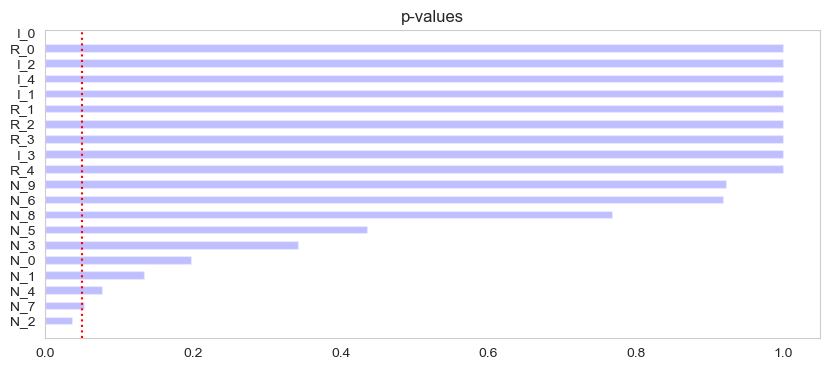

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)
plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')

#### Mean Decrease Impurity

In [8]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont['t1'])
oos_score = ml_cross_val_score(forest, trnsX, cont['bin'], cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi = mean_decrease_impurity(fit, trnsX.columns)

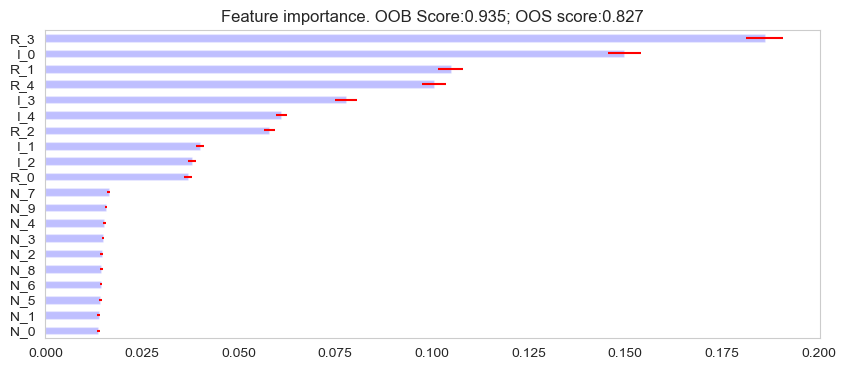

In [9]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

#### Mean Decrease Accuracy

In [10]:
mda = mean_decrease_accuracy(fit, trnsX, cont['bin'], cv_gen, scoring = accuracy_score)

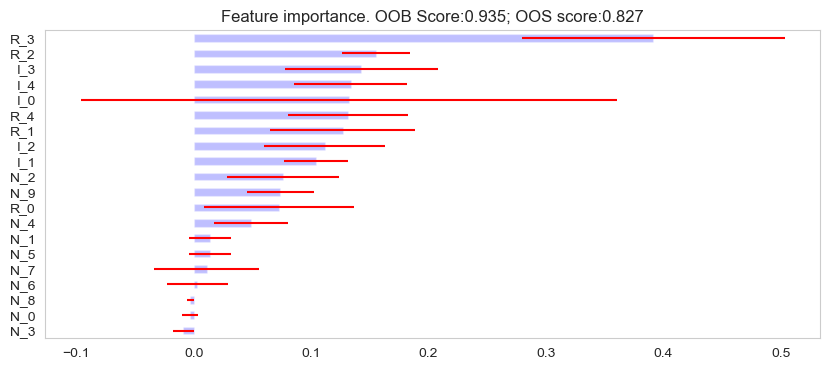

In [11]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


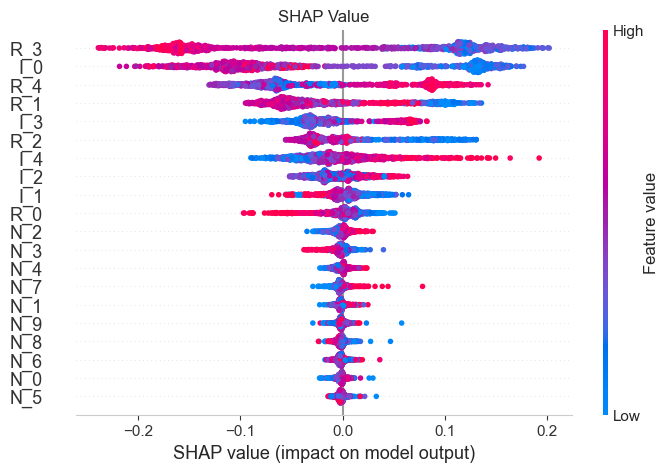

In [12]:
import shap
import tqdm

forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(trnsX)
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (8, 5)
)
plt.show()

#### PCA transformation

PCA : orthogonal 

In [13]:
Xdot = pd.DataFrame(get_orthogonal_features(trnsX), index = trnsX.index).add_prefix("PCA_")
Xdot.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
2021-04-12 00:20:37.594569,-1.563202,0.186989,-0.645809,-0.842797,0.605810,-0.278832,-0.390314,0.324967,0.857737,0.697391,-1.238060,2.202470,-0.244998,0.703477
2021-04-13 00:20:37.594569,0.968837,-0.162028,1.594090,-0.455705,-0.780448,-0.248923,0.494920,0.464467,0.164664,-0.275393,0.302101,-0.870366,0.007368,0.069569
2021-04-14 00:20:37.594569,1.225587,0.899282,0.190987,0.196739,-0.107180,0.001576,-0.173887,-1.544480,1.328974,0.913210,0.807530,0.566130,0.269315,0.503499
2021-04-15 00:20:37.594569,-0.178617,1.452068,0.369459,0.097140,0.231631,-0.239690,-0.961336,-0.194245,-0.866866,-0.830902,-1.055358,-1.831557,0.192030,0.429964
2021-04-16 00:20:37.594569,4.838266,3.726560,-0.215801,2.545331,1.681515,-1.323743,-0.523703,-1.589320,0.649489,-1.213941,0.653866,0.496335,0.812130,0.222244


Optimization terminated successfully.
         Current function value: 0.419888
         Iterations 7


Text(0.5, 1.0, 'p-values')

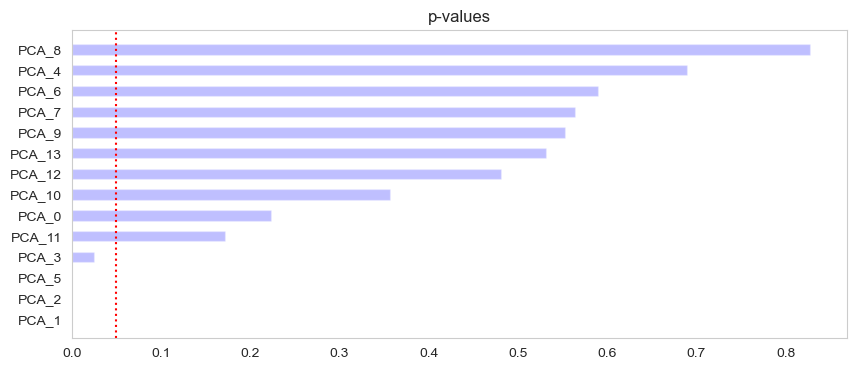

In [14]:
ols = sm.Logit(cont['bin'], Xdot).fit()

plt.figure(figsize=(10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending=True).index,
    ols.pvalues.sort_values(ascending=True),
    color='b', alpha=0.25, height=0.5
)
plt.axvline(0.05, ls=':', color='r')
plt.grid(False)
plt.title('p-values')

In [15]:
fit = forest.fit(X = Xdot, y = cont['bin'])
oob_score = fit.oob_score_
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont['t1'])
oos_score = ml_cross_val_score(forest, Xdot, cont['bin'], cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi_PCA = mean_decrease_impurity(fit, Xdot.columns)

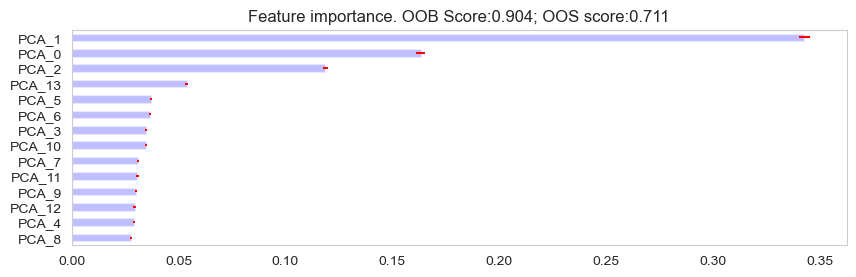

In [16]:
plot_feature_importance(
    mdi_PCA,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './PCA_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [17]:
mda_PCA = mean_decrease_accuracy(fit, Xdot, cont['bin'], cv_gen, scoring = accuracy_score)

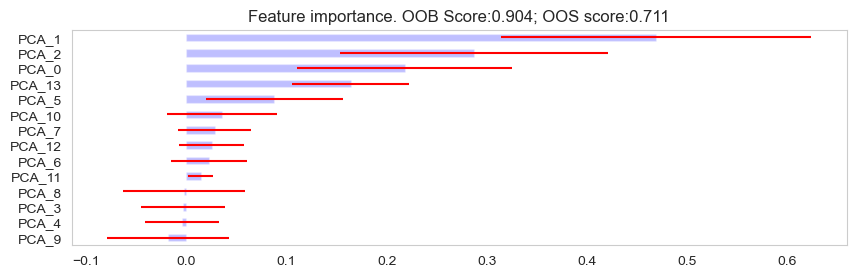

In [18]:
plot_feature_importance(
    mda_PCA,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './PCA_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


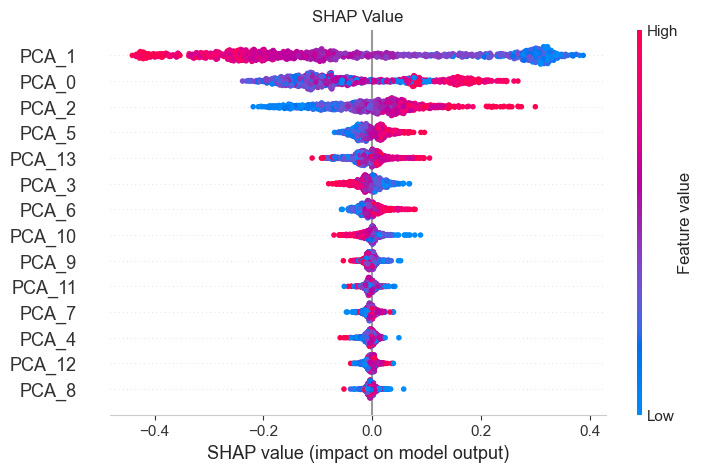

In [19]:
forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(Xdot)
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (8, 5)
)
plt.show()

#### PCA features + original features

In [20]:
Xdotdot = pd.concat([trnsX, Xdot], axis=1)

         Current function value: 0.413333
         Iterations: 35


Maximum Likelihood optimization failed to converge. Check mle_retvals


Text(0.5, 1.0, 'p-values')

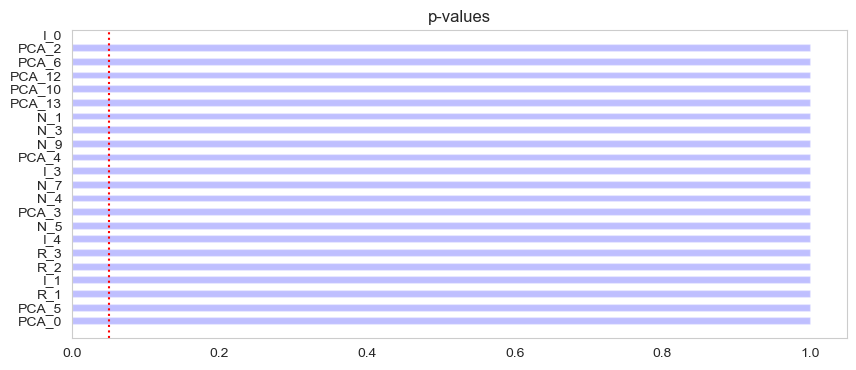

In [21]:
ols = sm.Logit(cont['bin'], Xdotdot).fit()

plt.figure(figsize=(10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending=True).index,
    ols.pvalues.sort_values(ascending=True),
    color='b', alpha=0.25, height=0.5
)
plt.axvline(0.05, ls=':', color='r')
plt.grid(False)
plt.title('p-values')

In [22]:
fit = forest.fit(X = Xdotdot, y = cont['bin'])
oob_score = fit.oob_score_
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont['t1'])
oos_score = ml_cross_val_score(forest, Xdotdot, cont['bin'], cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi_PCA2 = mean_decrease_impurity(fit, Xdotdot.columns)

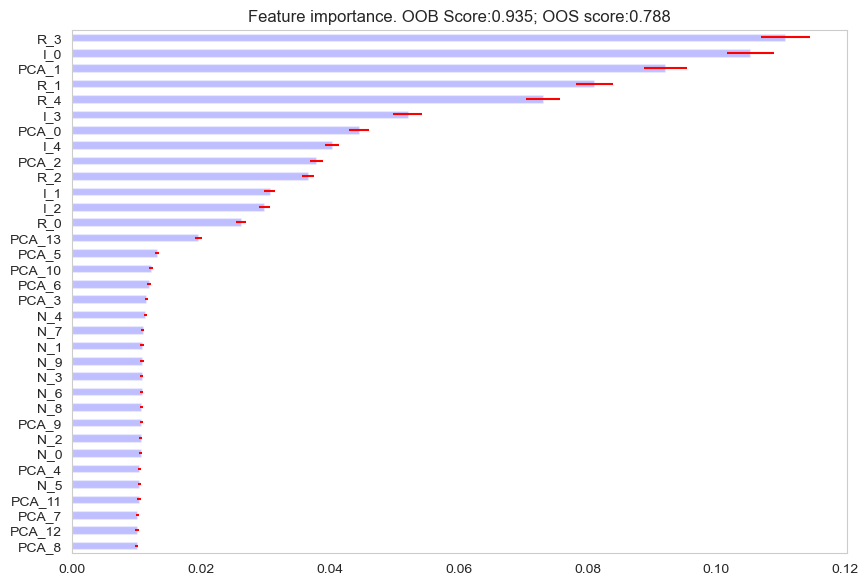

In [23]:
plot_feature_importance(
    mdi_PCA2,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './original_PCA_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [24]:
mda_PCA2 = mean_decrease_accuracy(fit, Xdotdot, cont['bin'], cv_gen, scoring = accuracy_score)

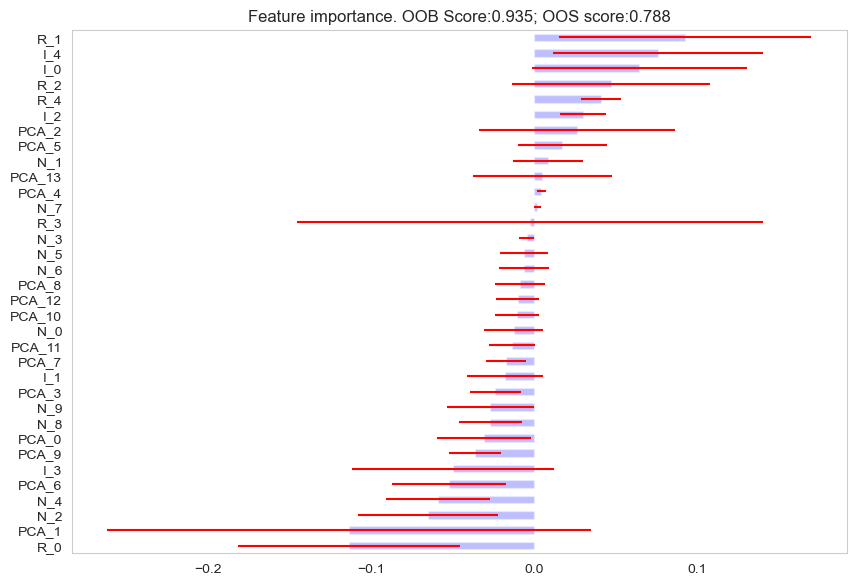

In [25]:
plot_feature_importance(
    mda_PCA2,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './original_PCA_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


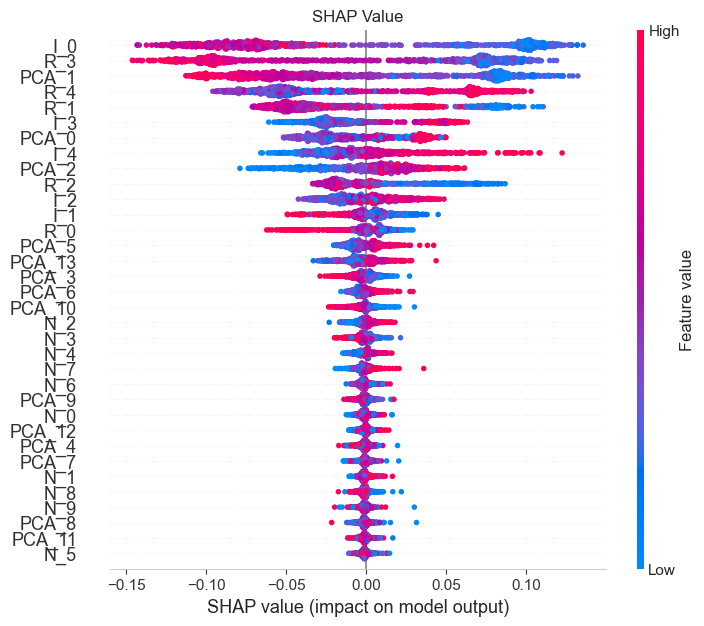

In [26]:
forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(Xdotdot)
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (8, 7)
)
plt.show()

#### Empirical Review

In [27]:
import yfinance as yf

start_date = '1980-01-01'
end_date = '2024-01-01'

apple = yf.download('AAPL', start = start_date, end = end_date)
apple_ret = np.log(apple.Close / apple.Close.shift(1)).dropna()
apple_ret.head()

[*********************100%%**********************]  1 of 1 completed


Date
1980-12-15   -0.053581
1980-12-16   -0.076231
1980-12-17    0.024450
1980-12-18    0.028580
1980-12-19    0.059239
Name: Close, dtype: float64

In [28]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(apple.Close, lookback = 21)

In [29]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(apple.Close, threshold = vol.mean())

In [30]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, apple['Close'], num_days = 1)

In [31]:
triple_barrier_events = get_events(
    close = apple['Close'],
    t_events = cusum_events,
    pt_sl = [1, 1],
    target = vol,
    min_ret = 0.01,
    num_threads = 1,
    vertical_barrier_times = vertical_barrier,
    side_prediction = None)
triple_barrier_events

iteritems is deprecated and will be removed in a future version. Use .items instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,t1,trgt,pt,sl
1980-12-26,1980-12-29,0.075620,1,1
1981-01-30,1981-02-02,0.047561,1,1
1981-04-23,1981-04-24,0.061646,1,1
1981-07-06,1981-07-07,0.040314,1,1
1981-09-15,1981-09-16,0.040589,1,1
...,...,...,...,...
2023-12-21,2023-12-22,0.012001,1,1
2023-12-22,2023-12-26,0.011677,1,1
2023-12-26,2023-12-27,0.011187,1,1
2023-12-27,2023-12-28,0.010700,1,1


In [32]:
from FinancialMachineLearning.multiprocess import multiprocess
from FinancialMachineLearning.features.concurrency import *
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = apple.Close.index, label_endtime = triple_barrier_events['t1'])

iteritems is deprecated and will be removed in a future version. Use .items instead.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [33]:
num_conc_events = num_conc_events.reindex(apple.Close.index).fillna(0)

In [34]:
avg_unique = multiprocess.mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
iteritems is deprecated and will be removed in a future version. Use .items instead.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


1980-12-26    1.00
1981-01-30    1.00
1981-04-23    1.00
1981-07-06    1.00
1981-09-15    1.00
              ... 
2023-12-21    0.50
2023-12-22    0.50
2023-12-26    0.50
2023-12-27    0.50
2023-12-28    0.75
Length: 4569, dtype: float64

In [35]:
_apple = apple.loc[cusum_events]

In [36]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 1, 11):
    try:
        df1 = np.log(_apple[['Close']]).dropna()
        df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d = d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index,'Close'], df2['Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

Degrees of freedom <= 0 for slice
divide by zero encountered in divide
invalid value encountered in multiply


d: 0.1, error: Invalid input, x is constant
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.30000000000000004, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-2.387710,1.452353e-01,1.0,4638.0,-2.862163,1.000000
0.4,-3.208628,1.949068e-02,1.0,7.0,-3.477583,0.907356
0.5,-1.676162,4.434347e-01,1.0,20.0,-3.021645,0.478436
0.6,-2.273737,1.805781e-01,1.0,51.0,-2.920142,0.524260
0.7,-5.158923,1.065850e-05,1.0,140.0,-2.882416,0.433726
0.8,-12.489115,2.972653e-23,1.0,417.0,-2.868496,0.211790
0.9,-24.874306,0.000000e+00,1.0,1392.0,-2.863619,0.016701
1.0,-49.940255,0.000000e+00,1.0,4637.0,-2.862164,-0.011706


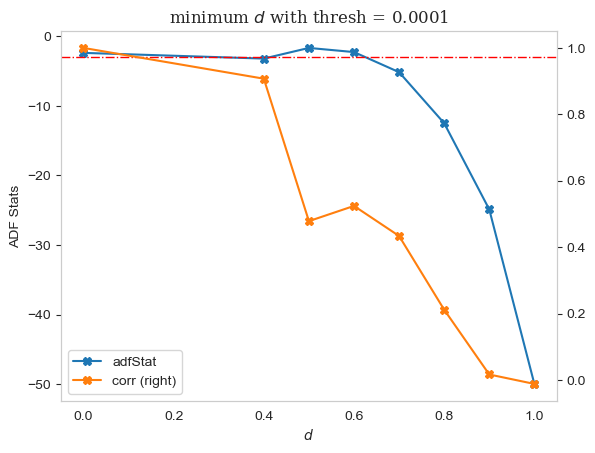

In [37]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
ax.set_title(r'minimum $d$ with thresh = 0.0001', fontfamily = 'Serif', fontsize = 12)
ax.set_xlabel(r'$d$')
ax.set_ylabel('ADF Stats');
ax.grid(False)
display(out)

In [38]:
frac = FractionalDifferentiatedFeatures.fracDiff_FFD(_apple[['Close']], 0.7)
_apple['fracdiff'] = frac

In [39]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi

_apple['mfi'] = money_flow_index(high = _apple.High, 
                                low = _apple.Low, 
                                close = _apple.Close, 
                                volume = _apple.Volume,
                                window = 3)
_apple['obv'] = on_balance_volume(close = _apple.Close, 
                                   volume = _apple.Volume)
_apple['rsi'] = rsi(close = _apple.Close, window = 3)
_apple['return'] = np.log(_apple['Close'] / _apple.Close.shift(1))
_apple['vwap'] = volume_weighted_average_price(high = _apple['High'],
                                              low = _apple['Low'],
                                              close = _apple['Close'],
                                              volume = _apple['Volume'],
                                              window = 3)
_apple['tsi'] = tsi(close = _apple['Close'],
                   window_fast = 3,
                   window_slow = 5)

In [40]:
from FinancialMachineLearning.features.microstructure import *

corwin_schultz = CorwinSchultz(_apple['High'], _apple['Low'])
cs_estimator = corwin_schultz.corwin_schultz_estimator(window = 3)
cs_estimator.dropna().head()

1981-07-06    0.0
1981-09-15    0.0
1981-12-18    0.0
1982-03-12    0.0
1982-09-14    0.0
Name: Spread, dtype: float64

In [41]:
_apple['corwin_schultz'] = cs_estimator

In [42]:
_apple

,Open,High,Low,Close,Adj Close,Volume,fracdiff,mfi,obv,rsi,return,vwap,tsi,corwin_schultz
1980-12-26,0.158482,0.159040,0.158482,0.158482,0.122637,55574400,NaN,NaN,55574400,NaN,NaN,NaN,NaN,NaN
1981-01-30,0.127232,0.127232,0.126116,0.126116,0.097591,46188800,NaN,NaN,9385600,NaN,-0.228439,NaN,NaN,NaN
1981-04-23,0.130580,0.131138,0.130580,0.130580,0.101046,58016000,NaN,56.494195,67401600,17.141978,0.034784,0.139234,NaN,NaN
1981-07-06,0.112165,0.112165,0.111049,0.111049,0.085932,16531200,NaN,49.680005,50870400,8.066815,-0.162014,0.126481,NaN,0.000000
1981-09-15,0.083147,0.083147,0.082589,0.082589,0.063909,19510400,NaN,68.697221,31360000,3.739545,-0.296095,0.117411,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800,0.371749,0.000000,75981763700,19.908576,-0.005563,195.054528,-41.008127,0.000000
2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300,0.645233,0.000000,75952844400,15.877895,-0.002845,194.255650,-52.846320,0.016774
2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700,1.268388,0.000000,76000932100,20.279342,0.000518,193.211173,-55.348938,0.005971
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34049900,1.743082,30.766559,76034982000,40.396432,0.002224,193.131276,-40.762030,0.000000


primary modeling

In [43]:
labels = meta_labeling(triple_barrier_events, _apple['Close'])
labels

,ret,trgt,bin
1980-12-26,-0.204225,0.075620,-1
1981-01-30,0.035396,0.047561,0
1981-04-23,-0.149571,0.061646,-1
1981-07-06,-0.256283,0.040314,-1
1981-09-15,0.236496,0.040589,1
...,...,...,...
2023-12-21,-0.005547,0.012001,0
2023-12-22,-0.002841,0.011677,0
2023-12-26,0.000518,0.011187,0
2023-12-27,0.002226,0.010700,0


In [44]:
triple_barrier_events['side'] = labels.bin
triple_barrier_events

,t1,trgt,pt,sl,side
1980-12-26,1980-12-29,0.075620,1,1,-1
1981-01-30,1981-02-02,0.047561,1,1,0
1981-04-23,1981-04-24,0.061646,1,1,-1
1981-07-06,1981-07-07,0.040314,1,1,-1
1981-09-15,1981-09-16,0.040589,1,1,1
...,...,...,...,...,...
2023-12-21,2023-12-22,0.012001,1,1,0
2023-12-22,2023-12-26,0.011677,1,1,0
2023-12-26,2023-12-27,0.011187,1,1,0
2023-12-27,2023-12-28,0.010700,1,1,0


In [45]:
meta_labels = meta_labeling(triple_barrier_events, _apple['Close'])
meta_labels

,ret,trgt,bin,side
1980-12-26,0.256637,0.075620,1,-1
1981-01-30,0.000000,0.047561,0,0
1981-04-23,0.175877,0.061646,1,-1
1981-07-06,0.344598,0.040314,1,-1
1981-09-15,0.236496,0.040589,1,1
...,...,...,...,...
2023-12-21,0.000000,0.012001,0,0
2023-12-22,0.000000,0.011677,0,0
2023-12-26,0.000000,0.011187,0,0
2023-12-27,0.000000,0.010700,0,0


In [46]:
_apple['uniqueness'] = avg_unique

In [47]:
_apple

,Open,High,Low,Close,Adj Close,Volume,fracdiff,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,uniqueness
1980-12-26,0.158482,0.159040,0.158482,0.158482,0.122637,55574400,NaN,NaN,55574400,NaN,NaN,NaN,NaN,NaN,1.00
1981-01-30,0.127232,0.127232,0.126116,0.126116,0.097591,46188800,NaN,NaN,9385600,NaN,-0.228439,NaN,NaN,NaN,1.00
1981-04-23,0.130580,0.131138,0.130580,0.130580,0.101046,58016000,NaN,56.494195,67401600,17.141978,0.034784,0.139234,NaN,NaN,1.00
1981-07-06,0.112165,0.112165,0.111049,0.111049,0.085932,16531200,NaN,49.680005,50870400,8.066815,-0.162014,0.126481,NaN,0.000000,1.00
1981-09-15,0.083147,0.083147,0.082589,0.082589,0.063909,19510400,NaN,68.697221,31360000,3.739545,-0.296095,0.117411,NaN,0.000000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800,0.371749,0.000000,75981763700,19.908576,-0.005563,195.054528,-41.008127,0.000000,0.50
2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300,0.645233,0.000000,75952844400,15.877895,-0.002845,194.255650,-52.846320,0.016774,0.50
2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700,1.268388,0.000000,76000932100,20.279342,0.000518,193.211173,-55.348938,0.005971,0.50
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34049900,1.743082,30.766559,76034982000,40.396432,0.002224,193.131276,-40.762030,0.000000,0.75


In [48]:
matrix = _apple[['fracdiff','mfi','obv','rsi','return','vwap','tsi','corwin_schultz','uniqueness']]
matrix = pd.concat([
    matrix,
    meta_labels['bin']
], axis = 1)
matrix.head()

,fracdiff,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,uniqueness,bin
1980-12-26,NaN,NaN,55574400,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1981-01-30,NaN,NaN,9385600,NaN,-0.228439,NaN,NaN,NaN,1.0,0.0
1981-04-23,NaN,56.494195,67401600,17.141978,0.034784,0.139234,NaN,NaN,1.0,1.0
1981-07-06,NaN,49.680005,50870400,8.066815,-0.162014,0.126481,NaN,0.0,1.0,1.0
1981-09-15,NaN,68.697221,31360000,3.739545,-0.296095,0.117411,NaN,0.0,1.0,1.0


In [49]:
matrix.dropna(inplace = True)

In [50]:
matrix

,fracdiff,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,uniqueness,bin
2000-03-13,-0.006135,30.420860,12729068800,42.157955,-0.035926,1.103861,2.952723,0.027535,0.50,1.0
2000-03-14,-0.044513,26.175136,12300489600,24.894075,-0.059981,1.079496,-23.841507,0.000000,0.75,1.0
2000-03-16,0.067267,34.007036,12678590400,54.091700,0.062039,1.066808,-7.071191,0.027203,1.00,1.0
2000-03-21,0.148057,69.336416,13202918400,77.785425,0.104384,1.101659,29.928676,0.000000,0.75,1.0
2000-03-22,0.143006,100.000000,13770915200,85.531729,0.066303,1.174421,52.443605,0.000000,0.75,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,1.182312,29.318767,76018886500,29.817236,-0.000770,195.786355,-24.682437,0.000000,0.50,0.0
2023-12-22,0.371749,0.000000,75981763700,19.908576,-0.005563,195.054528,-41.008127,0.000000,0.50,0.0
2023-12-26,0.645233,0.000000,75952844400,15.877895,-0.002845,194.255650,-52.846320,0.016774,0.50,0.0
2023-12-27,1.268388,0.000000,76000932100,20.279342,0.000518,193.211173,-55.348938,0.005971,0.50,0.0


secondary Modeling

In [59]:
from sklearn.model_selection import train_test_split

X = matrix.drop(['bin'], axis = 1)
y = matrix['bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

**Feature Importances**

In [60]:
ols = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.533438
         Iterations 6


Text(0.5, 1.0, 'p-values')

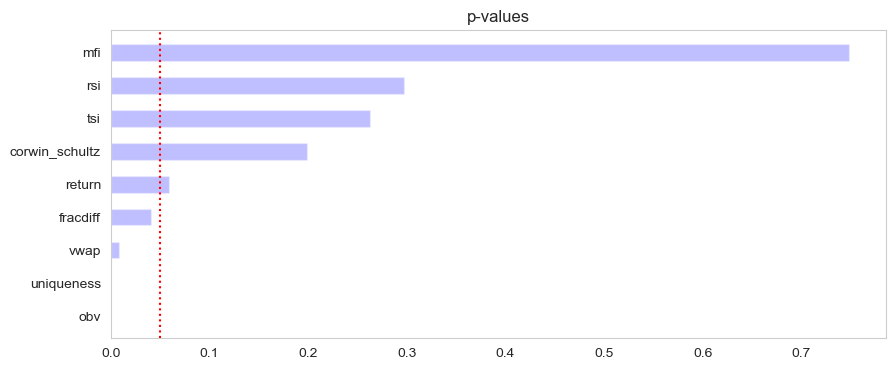

In [61]:
plt.figure(figsize=(10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending=True).index,
    ols.pvalues.sort_values(ascending=True),
    color='b', alpha=0.25, height=0.5
)
plt.axvline(0.05, ls=':', color='r')
plt.grid(False)
plt.title('p-values')

In [62]:
triple_barrier_events[-4198:]['t1']

2000-03-13   2000-03-14
2000-03-14   2000-03-15
2000-03-16   2000-03-17
2000-03-21   2000-03-22
2000-03-22   2000-03-23
                ...    
2023-12-21   2023-12-22
2023-12-22   2023-12-26
2023-12-26   2023-12-27
2023-12-27   2023-12-28
2023-12-28   2023-12-29
Name: t1, Length: 4198, dtype: datetime64[ns]

In [63]:
y_train

2000-03-13    1.0
2000-03-14    1.0
2000-03-16    1.0
2000-03-21    1.0
2000-03-22    0.0
             ... 
2020-08-04    0.0
2020-08-05    0.0
2020-08-06    0.0
2020-08-07    0.0
2020-08-10    0.0
Name: bin, Length: 3358, dtype: float64

In [74]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = X_train, y = y_train)
oob_score = fit.oob_score_
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = triple_barrier_events[-4198:-840]['t1'])
oos_score = ml_cross_val_score(forest, X_train, y_train, cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi = mean_decrease_impurity(fit, X_train.columns)

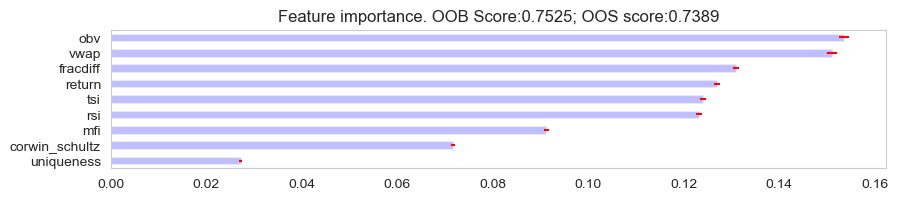

In [75]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDI_feature_importance_Apple.png'
)
plt.grid(False)
plt.show()

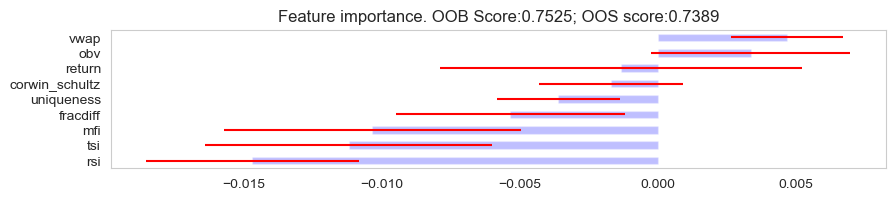

In [76]:
mda = mean_decrease_accuracy(fit, X_train, y_train, cv_gen, scoring=accuracy_score)
plot_feature_importance(
    mda,
    oob_score=oob_score,
    oos_score=oos_score,
    save_fig=True,
    output_path='./MDA_feature_importance_Apple.png'
)
plt.grid(False)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


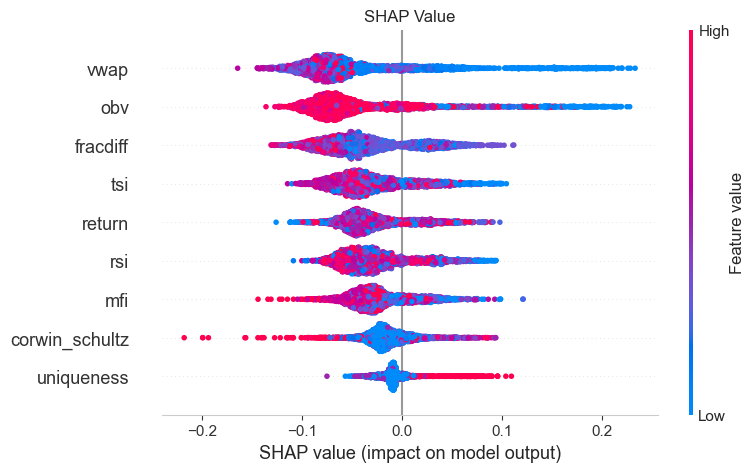

In [78]:
forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(X_train)
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (8, 5)
)
plt.show()